In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
import xgboost as xgb
from sklearn.preprocessing import label_binarize
import seaborn as sns
import warnings

# --------------------------
# 数据加载与预处理（假设已处理缺失值和非数值数据）
# --------------------------
# 加载处理后的数据集（561个传感器特征 + 标签）
X_train = pd.read_csv("X_train.csv")  # 特征维度: (10299, 561)
y_train = pd.read_csv("y_train.csv")  # 标签维度: (10299,)

X_test = pd.read_csv("X_test.csv")    # 特征维度: (4417, 561)
y_test = pd.read_csv("y_test.csv")    # 标签维度: (4417,)


# 编码标签为数值类型（6类活动）
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(np.ravel(y_train.to_numpy()))
y_test = label_encoder.transform(np.ravel(y_test.to_numpy()))
class_names = label_encoder.classes_  # ['WALKING', 'SITTING', ...]

# 数据分割（分层抽样保持类别分布）

# 标准化处理（仅在训练集上拟合）
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --------------------------
# 模型定义与配置（适配多分类）
# --------------------------
models = {
    "Logistic Regression": LogisticRegression(
        solver="lbfgs", max_iter=1000,
    ),
    "SVM": OneVsRestClassifier(SVC(probability=True, kernel="rbf")),
    "Random Forest": RandomForestClassifier(n_estimators=200, class_weight="balanced", n_jobs=-1),
    "XGBoost": xgb.XGBClassifier(
        objective="multi:softmax",
        num_class=6,
        eval_metric="mlogloss",
        n_jobs=-1
    ),
}

# --------------------------
# 评估函数（多分类支持）
# --------------------------


def evaluate_multi_class(model, X_train, X_test, y_train, y_test, model_name):
    # 训练模型
    model.fit(X_train, y_train)

    # 预测结果
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)  # 用于ROC曲线

    # 二值化标签（适配多类ROC）
    y_test_bin = label_binarize(y_test, classes=range(len(class_names)))

    # 计算指标
    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision (Macro)": precision_score(y_test, y_pred, average="macro"),
        "Recall (Macro)": recall_score(y_test, y_pred, average="macro"),
        "F1 (Macro)": f1_score(y_test, y_pred, average="macro"),
        "ROC AUC (OvO)": roc_auc_score(y_test, y_proba, multi_class="ovo"),
    }

    # 打印分类报告
    print(f"\n=== {model_name} Classification Report ===")
    print(classification_report(y_test, y_pred))

    # 绘制混淆矩阵
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # 绘制多类ROC曲线
    fig, ax = plt.subplots(figsize=(8, 6))
    for i in range(len(class_names)):
        RocCurveDisplay.from_predictions(
            y_test_bin[:, i],
            y_proba[:, i],
            name=f"Class {class_names[i]}",
            ax=ax,
            plot_chance_level=(i == 0),  # 仅显示一次参考线
        )
    ax.set_title(f"{model_name} ROC Curves (One-vs-Rest)")
    ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

    return metrics


# --------------------------
# 执行训练与评估
# --------------------------
results = {}
for name, model in models.items():
    print(f"\n\033[1m=== Training {name} ===\033[0m")
    metrics = evaluate_multi_class(
        model, X_train, X_test, y_train, y_test, name)
    results[name] = metrics

# --------------------------
# 结果对比（表格形式）
# --------------------------
results_df = pd.DataFrame(results).T
print("\n\033[1m=== Model Performance Comparison ===\033[0m")
print(results_df)

PCA降维后维度: 67

=== K-Means 聚类分布 ===
{0: 1102, 1: 278, 2: 724, 3: 745, 4: 862, 5: 612, 6: 262, 7: 557, 8: 532, 9: 194, 10: 667, 11: 817}

=== Hierarchical 聚类分布 ===
{0: 1149, 1: 496, 2: 175, 3: 720, 4: 1307, 5: 867, 6: 523, 7: 775, 8: 637, 9: 171, 10: 54, 11: 478}

=== 聚类性能对比 ===
              Silhouette  Calinski-Harabasz  Davies-Bouldin       ARI  \
K-Means         0.100254        2052.515126        2.306778  0.399633   
Hierarchical    0.090807        1945.140181        2.413507  0.430920   

                   NMI  Homogeneity  
K-Means       0.581487     0.680104  
Hierarchical  0.634354     0.723637  


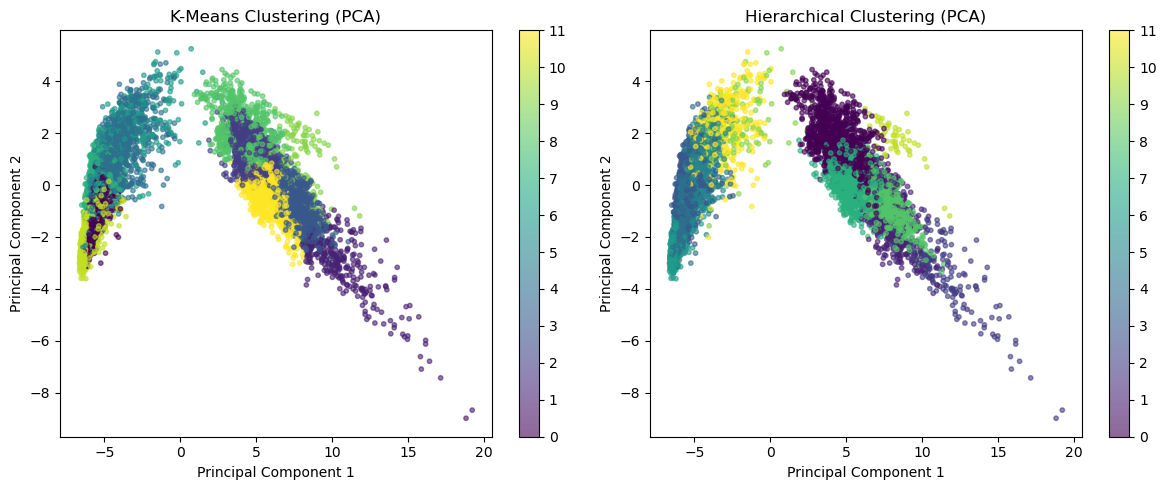

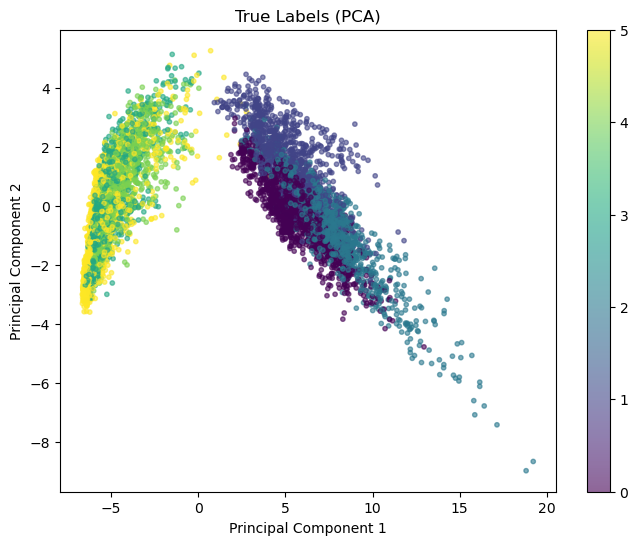

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import (
    silhouette_score, calinski_harabasz_score, davies_bouldin_score,
    adjusted_rand_score, normalized_mutual_info_score, homogeneity_score
)

# --------------------------
# Data Loading and Preprocessing
# --------------------------
# Load the processed dataset (561 sensor features + true labels)
X = pd.read_csv("X_train.csv")  # Feature dimensions: (10299, 561)
y_true = pd.read_csv("y_train.csv").to_numpy(
).flatten()  # True label dimensions: (10299,)

# Standardization
scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
X_scaled = X

# PCA Dimensionality Reduction (for faster computation and visualization)
pca = PCA(n_components=0.95)  # Retain 95% variance
X_pca = pca.fit_transform(X_scaled)
print(f"Dimensions after PCA: {X_pca.shape[1]}")

# --------------------------
# Define Clustering Algorithms and Parameters
# --------------------------
algorithms = {
    "K-Means": KMeans(n_clusters=12, init='k-means++', random_state=42, algorithm='elkan'),
    "Hierarchical": AgglomerativeClustering(n_clusters=12, linkage='ward'),
}

# --------------------------
# Evaluation Function (Internal + External Metrics)
# --------------------------


def evaluate_clustering(X, labels, y_true=None):
    metrics = {}

    # Internal evaluation metrics
    if len(np.unique(labels)) > 1:  # Exclude single-cluster cases
        metrics['Silhouette'] = silhouette_score(X, labels)
        metrics['Calinski-Harabasz'] = calinski_harabasz_score(X, labels)
        metrics['Davies-Bouldin'] = davies_bouldin_score(X, labels)
    else:
        metrics.update(
            {'Silhouette': np.nan, 'Calinski-Harabasz': np.nan, 'Davies-Bouldin': np.nan})

    # External evaluation metrics (requires true labels)
    if y_true is not None:
        metrics['ARI'] = adjusted_rand_score(y_true, labels)
        metrics['NMI'] = normalized_mutual_info_score(y_true, labels)
        metrics['Homogeneity'] = homogeneity_score(y_true, labels)

    return metrics


# --------------------------
# Perform Clustering and Evaluation
# --------------------------
results = {}
for name, model in algorithms.items():
    # Train clustering model
    cluster_labels = model.fit_predict(X_pca)

    # Compute evaluation metrics
    metrics = evaluate_clustering(X_pca, cluster_labels, y_true)
    results[name] = metrics

    # Print cluster distribution
    unique, counts = np.unique(cluster_labels, return_counts=True)
    print(f"\n=== {name} Cluster Distribution ===")
    print(dict(zip(unique, counts)))

# --------------------------
# Compare Results (Tabular Format)
# --------------------------
results_df = pd.DataFrame(results).T
print("\n\033[1m=== Clustering Performance Comparison ===\033[0m")
print(results_df)

# --------------------------
# Visualization (PCA Reduced Space)
# --------------------------
plt.figure(figsize=(18, 5))
for i, (name, model) in enumerate(algorithms.items(), 1):
    cluster_labels = model.fit_predict(X_pca)

    # Plot predicted clusters
    plt.subplot(1, 3, i)
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels,
                          cmap='viridis', s=10, alpha=0.6)
    plt.title(f"{name} Clustering (PCA)")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.colorbar(scatter, ticks=np.unique(cluster_labels))

plt.tight_layout()
plt.show()

# --------------------------
# Plot True Labels for Comparison
# --------------------------
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_true,
                      cmap='viridis', s=10, alpha=0.6)
plt.title("True Labels (PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(scatter, ticks=np.unique(y_true))
plt.show()